# 首先导入数据

In [16]:
try:
    import sklearn
    import cv2
    import captcha
    
except:
    !pip install scikit-learn
    !pip install opencv-python
    !apt update && apt install -y libsm6 libxext6  libxrender1 libxext-dev
    !pip install captcha
    import sklearn
    import cv2
    import captcha
    

import mxnet as mx
import sys
sys.path.append('/notebook/captcha_break/utils/')
from dataloader import *
%matplotlib inline

# 定义dataloader

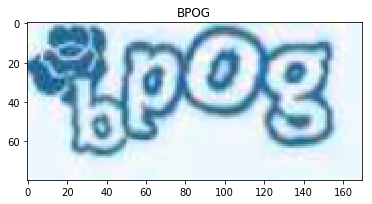

In [17]:
width, height, n_len, n_class = 170, 80, 4, 26+1
batch_size = 256

# characters = string.digits + string.ascii_uppercase
dataloader = DataLoader('../sample/')
def gen(batch_size= 128,trainMode = True):
    for  g in dataloader.generate(batchSize=batch_size ,trainMode=True):
        X   =  np.stack([cv2.resize(img,(width,height)) for img in g[0]])
        y =  np.array(g[1])
        yield [X, y]
    
import time
import pylab as pl
from IPython import display
for i in range(10):
    [X_test, y_test]  = next(gen(1))
    plt.imshow(X_test[0])
    plt.title(''.join([dataloader.remapDict[x] for x in y_test[0]]))
    
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(0.5)
display.clear_output(wait=True)

In [18]:
# 定义神经网络

In [19]:
from mxnet import gluon
import  mxnet.ndarray as nd
from mxnet.gluon import nn
from mxnet import autograd, nd

In [43]:
class Captcha(nn.Block):
    # 声明带有模型参数的层，这里我们声明了两个全连接层。
    def __init__(self, cls,**kwargs):
        # 调用 MLP 父类 Block 的构造函数来进行必要的初始化。这样在构造实例时还可以指定
        # 其他函数参数，例如后面章节将介绍的模型参数 params。
        super(Captcha, self).__init__(**kwargs)
        def _getOutput(cls):
            captchaOutput = nn.Sequential()
            captchaOutput.add(nn.Dense(256))
            captchaOutput.add(nn.Dense(128))
            captchaOutput.add(nn.Dense(cls))
            return captchaOutput
        with self.name_scope():
            self.feature = nn.Sequential(prefix='feature_')
            with self.feature.name_scope():
                for i in range(4):
                    self.feature.add(nn.Conv2D(32*2**i, kernel_size=3,padding=1, activation='relu'))
                    self.feature.add(nn.Conv2D(32*2**i, kernel_size=3,padding=1, activation='relu'))
                    self.feature.add(nn.MaxPool2D((2,2)))
                self.feature.add(nn.Flatten())
                self.feature.add(nn.Dropout(0.25))
            
            self.output1 =_getOutput(cls)
            self.output2 =_getOutput(cls)
            self.output3 =_getOutput(cls)
            self.output4 =_getOutput(cls) 


    # 定义模型的前向计算，即如何根据输入 x 计算返回所需要的模型输出。
    def forward(self, x):
        x = self.feature(x)
        return self.output1(x) , self.output2(x) , self.output3(x) , self.output4(x) 

In [44]:
# 定义loss

In [45]:
from mxnet.gluon import loss
net = Captcha(26,prefix = 'captcha_')

net.initialize(ctx=mx.gpu(2))
# net.collect_params().reset_ctx(mx.gpu(2))

trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
floss = loss.SoftmaxCrossEntropyLoss()

In [ ]:
net = Captcha(26,prefix = 'captcha_')
net.initialize(ctx=mx.gpu(2))
batch_size = 128
for epoch in range(1, 400):
    print('start epoch {}...'.format(epoch))
    if epoch % 5 == 0 :
        net.save_params('epoch_{}.params'.format(epoch))
    batchNum = 0
    loss = 0
    for g in gen(batch_size):
        x = nd.array(g[0]).transpose([0,3,1,2])
        x = x.as_in_context(mx.gpu(2))
        y = nd.array(g[1]).as_in_context(mx.gpu(2))

        with autograd.record():
            result = net(x)

            l = floss(result[0], y[:,0]) + \
                floss(result[1], y[:,1]) + \
                floss(result[2], y[:,2]) + \
                floss(result[3], y[:,3]) 
        l.backward()
        trainer.step(batch_size)

        loss += l.asnumpy().sum()

        batchNum += 1 # 表明遍历了一个批次

        if batchNum ==  len(dataloader.trainset_idx)// batch_size:

            break

    f =  open('log1.txt','a') 
    print('epoch %d, loss: %f' % (epoch,loss / len(dataloader.trainset_idx)))
    f.write('epoch %d, loss: %f' % (epoch,loss / len(dataloader.trainset_idx)) + '\n')
    f.close()


start epoch 1...
epoch 1, loss: 3.165387
start epoch 2...
epoch 2, loss: 3.079368
start epoch 3...
epoch 3, loss: 3.008631
start epoch 4...
epoch 4, loss: 2.928372
start epoch 5...
epoch 5, loss: 2.860269
start epoch 6...
epoch 6, loss: 2.791072
start epoch 7...
epoch 7, loss: 2.724661
start epoch 8...
